In [ ]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [17]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt

nx=9
ny=6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('my_computer_picture/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(150)

cv2.destroyAllWindows()

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

-----src_pt-----
[[336.1157  177.79561]
 [869.9744  187.58   ]
 [858.1659  540.1997 ]
 [270.54517 501.49823]]
-----dst_pt-----
[[ 100.  100.]
 [1180.  100.]
 [1180.  620.]
 [ 100.  620.]]


True

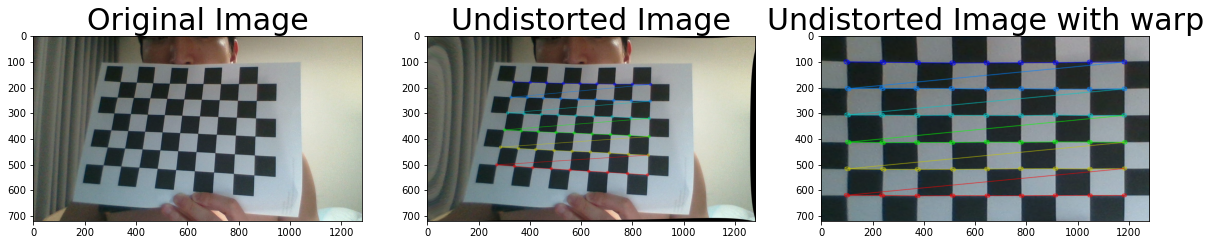

In [20]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('my_computer_picture/2020-10-16-211835.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Using Warp(10/26)
gray = cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

if ret == True:
    offset=100
    cv2.drawChessboardCorners(dst, (nx,ny), corners, ret)
    con=np.array(corners)
    con = con.reshape((-1,2))
        
    src_pt=np.float32( [ con[0] , con[nx-1] ,con[-1], con[-nx] ] )
    dst_pt = np.float32( [ [offset,offset], [img.shape[1]-offset, offset], [img.shape[1]-offset, img.shape[0]-offset], [offset, img.shape[0]-offset] ] )
    
    print("-----src_pt-----")
    print(src_pt)
        
    print("-----dst_pt-----")
    print(dst_pt)
        
    M=cv2.getPerspectiveTransform(src_pt,dst_pt)
    warped = cv2.warpPerspective(dst, M, (img.shape[1],img.shape[0]))

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "my_computer_picture/my_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(dst) # only using distortion
ax2.set_title('Undistorted Image', fontsize=30)

ax3.imshow(warped)# with warp
ax3.set_title('Undistorted Image with warp', fontsize=30)

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imwrite('my_computer_picture/test_undist.jpg',dst) # only using distortion
cv2.imwrite('my_computer_picture/test_undist_with_warp.jpg',warped) # with warp